In [1]:
from tahoe import execute_async
import pandas as pd
import json
from tqdm import tqdm
from copy import deepcopy

In [2]:
execute_async("""SELECT COUNT(*) FROM sweeper.attribute_extraction_events WHERE action=4""")

[(27002,)]

In [3]:
res = execute_async("""SELECT task_id, extraction_result, dt, hr FROM sweeper.attribute_extraction_events WHERE action=4""")

In [4]:
df = pd.DataFrame(res)

In [5]:
df.columns = ['task_id', 'extraction_result', 'dt', 'hr']

In [6]:
df

,task_id,extraction_result,dt,hr
0,product_attribution_md_b47954093999c7a9def2793...,"{""Styles"": [""Not Sure""], ""Age Range Descriptio...",2023-04-05,20
1,product_attribution_md_4a815d2f82b3c4e1af3ca22...,"{""Compatible Brand/Model"": [""Iphone & Samsung""...",2023-04-05,20
2,product_attribution_md_55e0c72bedf31fdda57f9f7...,"{""Age Range Description"": [""Not Sure""], ""Numbe...",2023-03-31,13
3,product_attribution_md_51b7b8bc597b7d991124f53...,"{""Age Range Description"": [""Not Sure""], ""Use"":...",2023-03-31,13
4,product_attribution_md_e099f35406b64c502772688...,"{""Item Weight (Include Unit of Measure)"": [""no...",2023-03-31,13
...,...,...,...,...
26997,product_attribution_md_8f88c4dd85fe1aafe9de2cd...,"{""Model or Model Number"": [], ""Brand Name"": []...",2023-04-05,13
26998,product_attribution_md_6c60de7a03e41f60227697e...,"{""Model or Model Number"": [], ""Brand Name"": []...",2023-04-05,13
26999,product_attribution_md_88eea10fd6e02c62323a084...,"{""Primary Color"": [""Green""], ""Certifications"":...",2023-04-05,13
27000,product_attribution_md_1a46f1d21523e9d675b7a25...,"{""Theme"": [""Not Sure""], ""Model or Model Number...",2023-04-05,13


In [7]:
df_orig = pd.read_json('input/product_attr_extract_md_03252023.json', lines=True)

In [8]:
len(df_orig)

26066

In [9]:
df_merge = df_orig.merge(df, on='task_id', how='inner')

In [16]:
len(df_merge), len(set(df_merge.task_id)), len(set(df_orig.task_id))

(26004, 26002, 26066)

In [11]:
len(set(df_merge.category_path))

712

<Axes: ylabel='category_path'>

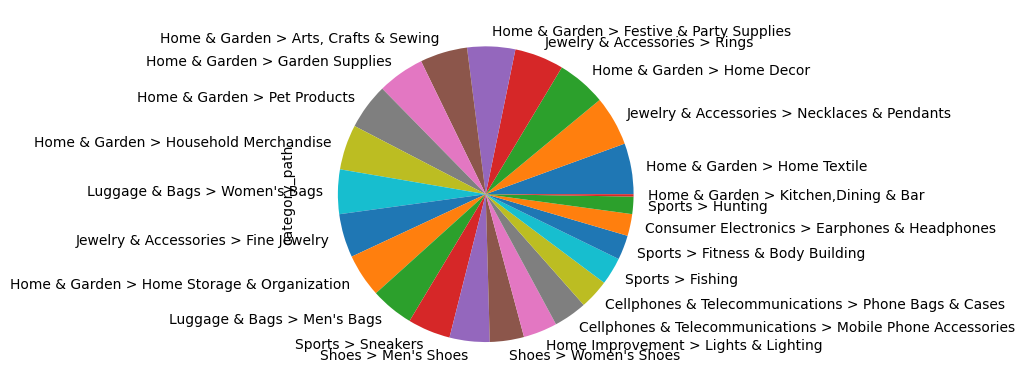

In [12]:
df_merge.category_path.apply(lambda x: ' > '.join(x.split(' > ')[:2])).value_counts().plot.pie()

In [18]:
df_merge.to_json('output/product_attr_extract_md_03252023_result_04172023.json', lines=True, orient='records')

In [13]:
df_merge_sample = df_merge.sample(10)

In [14]:
def clean_human_result_return(d_):
    try:
        d = deepcopy(d_)
        for k in d:
            if len(d[k]) > 0 and d[k][0].strip().lower() == 'not sure':
                d[k] = []
        return d
    except Exception as e:
        print(d, e)

In [15]:
from copy import deepcopy
import hashlib
from collections import OrderedDict
import json
def sortOD(od):
    res = OrderedDict()
    for k, v in sorted(od.items()):
        if isinstance(v, dict):
            res[k] = sortOD(v)
        else:
            res[k] = deepcopy(v)
    return res

In [245]:
# df_merge_sample['preloading_result'] = df_merge_sample['extraction_result'].apply(lambda x: json.dumps(clean_human_result_return(json.loads(x))))

In [ ]:
# df_merge_sample.to_json('input_preload/product_attr_extract_md_oaipreload_04062023.json')

In [173]:
rec = df_merge.sample(1).to_dict('records')[0]
rec2 = df_merge.sample(1).to_dict('records')[0]

In [174]:
human_result = json.loads(rec['extraction_result'])
human_result2 = json.loads(rec2['extraction_result'])

In [175]:
def clean_human_result(d):
    for k in d:
        if len(d[k]) > 0 and d[k][0].strip().lower() == 'not sure':
            d[k] = []

In [176]:
clean_human_result(human_result)
clean_human_result(human_result2)

In [185]:
assert set([i['attribute_field'] for i in rec['attribute_config']]) == set(human_result)
assert set([i['attribute_field'] for i in rec2['attribute_config']]) == set(human_result2)

# check oai quality compared to humans

In [177]:
import random

In [178]:
def sample_from_strified_list(t):
    l = eval(t)
    if len(l) > 1:
        return random.sample(l, min(3, len(l))) + ['... and more']
    else:
        return "Free text, please extract from product title and description"

In [186]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
title = rec['title']
desp = rec['product_description']
attrs = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec['attribute_config']])
attr_template = {i['attribute_field']: [] for i in rec['attribute_config']}
human_result = json.loads(rec['extraction_result'])
clean_human_result(human_result)
assert set(attr_template) == set(human_result)

title2 = rec2['title']
desp2 = rec2['product_description']
attrs2 = '\n'.join([f"{i['attribute_field']}: {sample_from_strified_list(i['category_attributevalue'])}" for i in rec2['attribute_config']])
attr_template2 = {i['attribute_field']: [] for i in rec2['attribute_config']}
human_result2 = json.loads(rec2['extraction_result'])
clean_human_result(human_result2)
assert set(attr_template2) == set(human_result2)

msgs = [
        {"role": "system", "content": """You are a state of art NER system that extracts all attribute key value pairs from e commerce data by filling in the blank."""},
        {"role": "user", "content": f"""[title start] {title} [title end] [description start] {desp} [description end] Fill in the blank here: {json.dumps(attr_template)}"""},
        {"role": "assistant", "content": json.dumps(human_result)},
        {"role": "user", "content": f"""Do better, you are state of art. [title start] {title2} [title end] [description start] {desp2} [description end] Fill in the blank here: {json.dumps(attr_template2)}"""},
    ]
res = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=msgs,
  temperature=0,
  max_tokens=500
)

In [187]:
res

<OpenAIObject chat.completion id=chatcmpl-71zV8x9U2A3wHh3XnO1egNPWUPRti at 0x7f2cfd73d6d0> JSON: {
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "{\"Age Range Description\": [], \"Alpha Size\": [], \"Brand Name\": [], \"Closure Type\": [\"COVER\"], \"Department\": [\"Women\"], \"Item Features\": [\"Chains\"], \"Materials\": [\"PU\", \"Synthetic Leather\"], \"Model or Model Number\": [], \"Occasion & Lifestyle\": [\"Versatile\"], \"Primary Color\": [], \"Theme\": [\"Animal Prints\", \"Vintage\", \"Fashion\"]}",
        "role": "assistant"
      }
    }
  ],
  "created": 1680709094,
  "id": "chatcmpl-71zV8x9U2A3wHh3XnO1egNPWUPRti",
  "model": "gpt-3.5-turbo-0301",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 83,
    "prompt_tokens": 702,
    "total_tokens": 785
  }
}

In [188]:
rec2['title']

'2023 New Retro all-match Lizard Pattern Women Bag\\Handbag Leather Fashion Chains Female Shoulder Messenger Bag Long Clutch Trend Brand'

In [189]:
rec2['product_description']

'Shape : Clutch\nHandbags Type : Shoulder Bags\nTypes of bags : Shoulder &amp; Crossbody Bags\nMain Material : PU\nClosure Type : COVER\nHardness : HARD\nExterior : NONE\nStyle : vintage\nLining Material : Synthetic Leather\nOccasion : Versatile\nGender : WOMEN\nPattern Type : Animal Prints\nNumber of Handles/Straps : Single\nDecoration : Chains\nItem Type : Handbags\nColors as pictures : Fashion\nLadies handbag designer: Lady bag\nFashion brand handbags: ladies messenger bags'

In [190]:
human_result2

{'Age Range Description': ['Adult'],
 'Theme': [],
 'Model or Model Number': [],
 'Brand Name': [],
 'Closure Type': [],
 'Alpha Size': [],
 'Occasion & Lifestyle': [],
 'Primary Color': [],
 'Materials': ['Polyurethane (PU)'],
 'Department': ['Women'],
 'Item Features': []}

In [191]:
json.loads(res['choices'][0]['message']['content'])

{'Age Range Description': [],
 'Alpha Size': [],
 'Brand Name': [],
 'Closure Type': ['COVER'],
 'Department': ['Women'],
 'Item Features': ['Chains'],
 'Materials': ['PU', 'Synthetic Leather'],
 'Model or Model Number': [],
 'Occasion & Lifestyle': ['Versatile'],
 'Primary Color': [],
 'Theme': ['Animal Prints', 'Vintage', 'Fashion']}

# compare human vs ai for each category

In [200]:
(df_orig['category_path'].value_counts() == 1).sum(), (df_orig['category_path'].value_counts() > 1).sum()

(70, 642)

In [201]:
(df_merge['category_path'].value_counts() == 1).sum(), (df_merge['category_path'].value_counts() > 1).sum()

(75, 609)

In [204]:
tmp = df_merge['category_path'].value_counts()

In [209]:
rare_cats = set(tmp[tmp==1].to_dict())

In [210]:
df_not_rare_start_sample_2 = df_merge[df_merge.category_path.apply(lambda x: x not in rare_cats)].groupby('category_path').sample(2)
df_rare = df_merge[df_merge.category_path.apply(lambda x: x in rare_cats)]

In [218]:
shot_dict = {}
eval_dict = {}
for i in df_not_rare_start_sample_2.to_dict('records'):
    if i['category_path'] not in shot_dict:
        shot_dict[i['category_path']] = i 
    else:
        eval_dict[i['category_path']] = i


In [219]:
for i in df_rare.to_dict('records'):
    cands = [shot_dict[j] for j in shot_dict if i['category_path'].startswith(' > '.join(j.split(' > ')[:2]))]
    shot_dict[i['category_path']] = random.sample(cands, 1)[0]
    eval_dict[i['category_path']] = i

In [224]:
len(set([json.dumps(shot_dict[i]) for i in shot_dict]).intersection(set([json.dumps(eval_dict[i]) for i in eval_dict])))

0

In [225]:
len(shot_dict), len(eval_dict)

(684, 684)

In [ ]:
# Note: you need to be using OpenAI Python v0.27.0 for the code below to work
import openai
reses = {}


In [257]:
len(shot_dict)

684

In [256]:
len(reses)

679

In [249]:
import time

In [258]:
for cat in tqdm(shot_dict):
    if cat in reses:
        continue
    try:
        rec = shot_dict[cat] 
        rec2 = eval_dict[cat]
        title = rec['title']
        desp = rec['product_description']
        attr_template = {i['attribute_field']: [] for i in rec['attribute_config']}
        human_result = json.loads(rec['extraction_result'])
        clean_human_result(human_result)
        assert set(attr_template) == set(human_result)

        title2 = rec2['title']
        desp2 = rec2['product_description']
        attr_template2 = {i['attribute_field']: [] for i in rec2['attribute_config']}
        human_result2 = json.loads(rec2['extraction_result'])
        clean_human_result(human_result2)
        assert set(attr_template2) == set(human_result2)

        msgs = [
                {"role": "system", "content": """You are a state of art NER system that extracts all attribute key value pairs from e commerce data by filling in the blank."""},
                {"role": "user", "content": f"""[title start] {title} [title end] [description start] {desp} [description end] Fill in the blank here: {json.dumps(attr_template)}"""},
                {"role": "assistant", "content": json.dumps(human_result)},
                {"role": "user", "content": f"""Do better, you are state of art. [title start] {title2} [title end] [description start] {desp2} [description end] Fill in the blank here: {json.dumps(attr_template2)}"""},
            ]
        res = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=msgs,
            temperature=0,
            max_tokens=500
        )
        reses[cat] = res
    except Exception as e:
        print(cat, e)

 83%|████████▎ | 568/684 [00:14<00:03, 37.39it/s]

Sports > Fitness & Body Building > Boxing > Boxing Jerseys This model's maximum context length is 4097 tokens. However, your messages resulted in 10343 tokens. Please reduce the length of the messages.


100%|██████████| 684/684 [00:20<00:00, 33.66it/s]


In [259]:
len(reses)

683

In [263]:
def parse_json_or_none(text):
    try:
        return json.loads(text)
    except Exception as e:
        print(text, e)
        return None

In [333]:
df_reses = pd.DataFrame([(j, reses[j]['choices'][0]['message']['content']) for j in reses])

In [334]:
df_reses.columns = ['category_path', 'oai_extraction_results_json']

In [ ]:
df_reses['oai_extraction_results'] = df_reses['oai_extraction_results_json'].apply(parse_json_or_none)

In [336]:
(df_reses['oai_extraction_results'].apply(lambda x: x is None)).mean()

0.09956076134699854

In [337]:
df_reses.loc[df_reses['oai_extraction_results'].apply(lambda x: x is None), 'oai_extraction_results'] = \
    df_reses.loc[df_reses['oai_extraction_results'].apply(lambda x: x is None), 'oai_extraction_results_json'].apply( 
        lambda x: x.replace(',}', '}').replace(', }', '}').replace("'']", '"]')
    ).apply(
        parse_json_or_none
    )

{"Brand Name": [], "Care Instructions": [], "Construction": [], "Fabric Warmth Description": [], "Firmness": [], "Installation or Mount Compatibility": [], "Is Stain Resistant": [], "Item Features": [], "Item Height (Include Unit of Measure)": ["45cm"], "Item Length (Include Unit of Measure)": ["45cm"], "Item Weight (Include Unit of Measure)": [], "Item Width (Include Unit of Measure)": ["45cm"], "Material-Free": [], "Materials": ["Polyester Peach Skin"], "Model or Model Number": [], "Occasion & Lifestyle": [], "Pattern": ["Christmas-themed elements"], "Primary Color": [], "Shape": [], "Size": ["45cm x 45cm/17.72" x 17.72" (Approx.)"], "Styles": [], "Theme": ["Christmas"], "Thread Count (Include Unit of Measure)": [], "Use": ["Home decoration", "Christmas decoration"], "Water Resistance Level": [], "Weave Type": []} Expecting ',' delimiter: line 1 column 623 (char 622)
{"Alpha Size": ["61cm * 180cm"], "Primary Color": []} 

Note: The size "61cm * 180cm" is extracted as the value for th

In [338]:
(df_reses['oai_extraction_results'].apply(lambda x: x is None)).mean()

0.004392386530014641

In [343]:
df_reses.loc[df_reses['oai_extraction_results'].apply(lambda x: x is None), 'oai_extraction_results'] = \
    df_reses.loc[df_reses['oai_extraction_results'].apply(lambda x: x is None), 'oai_extraction_results_json'].apply( 
        lambda x: x.replace('" ', 'inch').split('\n')[0].split(' - ')[0]
    ).apply(
        parse_json_or_none
    )

In [344]:
(df_reses['oai_extraction_results'].apply(lambda x: x is None)).mean()

0.0

In [345]:
df_reses

,category_path,oai_extraction_results_json,oai_extraction_results
0,Cellphones & Telecommunications > Mobile Phone...,"{""Compatible Brand/Model"": [], ""Theme"": [], ""C...","{'Compatible Brand/Model': [], 'Theme': [], 'C..."
1,Cellphones & Telecommunications > Mobile Phone...,"{""Compatible Brand/Model"": [""iPhone"", ""Samsung...","{'Compatible Brand/Model': ['iPhone', 'Samsung..."
2,Cellphones & Telecommunications > Mobile Phone...,"{""Compatible Brand/Model"": [""ipod, ipad, iphon...","{'Compatible Brand/Model': ['ipod, ipad, iphon..."
3,Cellphones & Telecommunications > Mobile Phone...,"{""Compatible Brand/Model"": [], ""Certifications...","{'Compatible Brand/Model': [], 'Certifications..."
4,Cellphones & Telecommunications > Mobile Phone...,"{""Compatible Brand/Model"": [""iPhone, iPad, Sam...","{'Compatible Brand/Model': ['iPhone, iPad, Sam..."
...,...,...,...
678,"Home & Garden > Kitchen,Dining & Bar > Disposa...","{""Age Range Description"": [], ""Alpha Size"": []...","{'Age Range Description': [], 'Alpha Size': []..."
679,Home & Garden > Pet Products > Cat Supplies > ...,"{""Brand Name"": [], ""Life Stage"": [""Small pets,...","{'Brand Name': [], 'Life Stage': ['Small pets,..."
680,Luggage & Bags > Women's Bags > Hobos,"{""Age Range Description"": [""Adult""], ""Theme"": ...","{'Age Range Description': ['Adult'], 'Theme': ..."
681,Sports > Fishing > Fishing Lines,"{""Alpha Size"": [], ""Primary Color"": []} - Ther...","{'Alpha Size': [], 'Primary Color': []}"


In [365]:
df_eval = pd.DataFrame([(i, eval_dict[i]) for i in eval_dict])
df_eval.columns = ['category_path', 'md_result']

In [366]:
df_eval['human_extraction_results'] = df_eval['md_result'].apply(lambda x: x['extraction_result'])

In [367]:
df_eval["text"] = df_eval['md_result'].apply(lambda x: x['text'])

In [368]:
df_merge_compare = df_reses.merge(df_eval, on='category_path', how='inner')

In [370]:
df_merge_compare = df_merge_compare[[ 
    'category_path', 'text', 'oai_extraction_results_json', 'oai_extraction_results', 'human_extraction_results', 'md_result'
]]

In [371]:
df_merge_compare.to_csv('analysis/compare_offshore_md_with_oai.csv', index=False)